#Segment Anything (Meta) -- Goat Images

##Setup and installment

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

%cd {HOME}

# Install Segment Anything
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

# Install jupyter widget
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

# Retrieve weights from Meta
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

# Create data folder
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

HOME: /content
/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-rruy8n4h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-rruy8n4h
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=e952d3dca836f4d4e4900a5fdc445dadea474d5a3393dcdeac952eeeb21dbe4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-0v6gqn3i/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 6.6 MB/s eta 0:00:00
     ━━

##Downloading example image

In [ ]:
%cd {HOME}
# !mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://i.ibb.co/MkJvFLq/example.png
!mv {HOME}/data/example.png {HOME}/data/goat.png

/content
mkdir: cannot create directory ‘/content/data’: File exists
/content/data


##Loading model

In [ ]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

##Loading mask predictor

In [ ]:
mask_predictor = SamPredictor(sam)

##Loading image

In [ ]:
IMAGE_NAME = "goat.png"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

##Drawing bounding box

In [ ]:
# helper function that loads an image before adding it to the widget
import base64
from jupyter_bbox_widget import BBoxWidget

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
# Print the coordinates for reference
widget.bboxes

[{'x': 60, 'y': 15, 'width': 560, 'height': 462, 'label': ''}]

##Generate masks with Segment Anything

In [ ]:
from segment_anything.modeling import mask_decoder
import numpy as np
import cv2
import supervision as sv

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [ ]:
masks

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Get the mask
mask = detections.mask

# Squeeze any singleton dimensions (if there's only one mask)
mask = np.squeeze(mask)

# Ensure the mask is a boolean mask
mask = mask.astype(bool)

# Create a new image with 4 channels (RGB + alpha)
cutout = np.zeros((image_bgr.shape[0], image_bgr.shape[1], 4), dtype=np.uint8)

# Set RGB values
cutout[..., :3] = image_bgr

# Set alpha channel
cutout[..., 3] = mask.astype(np.uint8) * 255  # Set alpha to 255 for non-transparent regions

# Convert the image from BGR to RGBA
cutout_rgba = cv2.cvtColor(cutout, cv2.COLOR_BGRA2RGBA)
cutout_rgba = cv2.copyMakeBorder(cutout_rgba, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=[0,0,0,255])

# Save the image with transparency to a file (e.g., PNG)
output_file = 'output.png'
Image.fromarray(cutout_rgba).save(output_file)

# Display the image using matplotlib
img = Image.open(output_file)
plt.imshow(img)
plt.axis('off')  # Optional: Turn off axes
plt.show()

NameError: ignored

##Visualize the results

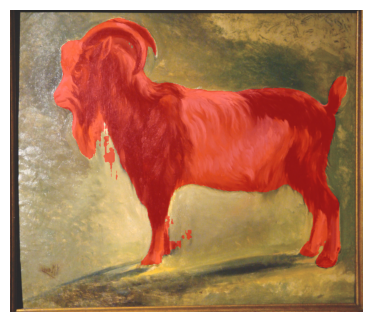

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# sv.plot_images_grid(
#     images=[source_image, segmented_image],
#     grid_size=(1, 2),
#     titles=['source image', 'segmented image']
# )


import cv2
import matplotlib.pyplot as plt

# Assuming `source_image` is your image data with incorrect channel ordering
rgb_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(rgb_image)


In [ ]:
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)

for detection in detections:
    coordinates = detection.xyxy
    print(coordinates)

AttributeError: ignored

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def seperate(detections, image_bgr):

  # Get the mask
  mask = detections.mask
  # Squeeze any singleton dimensions (if there's only one mask)
  mask = np.squeeze(mask)

  # Ensure the mask is a boolean mask
  mask = mask.astype(bool)

  # Create a new image with 4 channels (RGB + alpha)
  cutout = np.zeros((image_bgr.shape[0], image_bgr.shape[1], 4), dtype=np.uint8)

  # Set RGB values
  cutout[..., :3] = image_bgr

  # Set alpha channel
  cutout[..., 3] = mask.astype(np.uint8) * 255  # Set alpha to 255 for non-transparent regions

  # Convert the image from BGR to RGBA
  cutout_rgba = cv2.cvtColor(cutout, cv2.COLOR_BGRA2RGBA)

  # Save the image with transparency to a file (e.g., PNG)
  output_file = 'output.png'
  Image.fromarray(cutout_rgba).save(output_file)

  # # Display the image using matplotlib
  Image.open(output_file)

In [ ]:
seperate(detections, source_image)

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def yolo_convertor(yolo_tensor):
  boxes = []
  for box in yolo_tensor:
      x_center, y_center, width, height = box
      x1 = x_center - width / 2
      y1 = y_center - height / 2
      x2 = x_center + width / 2
      y2 = y_center + height / 2
      boxes.append([x1, y1, x2, y2])

  boxes = np.array(boxes)
  return boxes

In [ ]:
import os
import cv2
import numpy as np
import re

def load_images_and_tensors(image_folder, text_folder):
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]
    data = []

    for image_file in image_files:
        # Load image
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)

        # Load corresponding text file
        text_file = os.path.splitext(image_file)[0] + '.txt'
        text_path = os.path.join(text_folder, text_file)
        with open(text_path, 'r') as f:
            tensor_str = f.read()
            # Remove non-numeric characters and extra spaces
            tensor_str = re.sub(r'[^0-9.,\s]', '', tensor_str).strip()
            # Convert string to numpy array
            try:
              tensor = np.array([list(map(float, line.split(','))) for line in tensor_str.split('\n') if line.strip()])
            except:
              continue


        data.append({'image': image, 'tensor': tensor, 'image_path': image_path})

    return data

In [ ]:
yolo_test_data = load_images_and_tensors('/content/yolo_test', '/content/yolo_test')
yolo_convertor(yolo_test_data[2]['tensor'])[0]

array([ 27.34935,   5.13365, 410.97365, 329.72635])

In [ ]:
import numpy as np
import cv2
import supervision as sv

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = yolo_convertor(yolo_test_data[1]['tensor'])[0]

image_bgr = cv2.imread(yolo_test_data[1]['image_path'])
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
coordinates = detections.xyxy
print(coordinates)

[[181  21 717 494]
 [181  16 717 495]
 [181  16 718 495]]


In [ ]:
# For each detection, get the mask
mask = detection.mask

# Ensure the mask is a boolean mask
mask = mask.astype(bool)

# Create a new image filled with zeros (black)
cutout = np.zeros_like(image_bgr)

# Apply the mask to the image. This will copy the pixels from the original image
# where the mask is True (the area of the mask), and leave all other areas as black.
cutout[mask] = image_bgr[mask]

# Now 'cutout' is an image where only the area of the mask is visible.

# Convert the image to RGBA
image_rgba = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGBA)

# Create a new image filled with transparency
cutout = np.zeros_like(image_rgba)

# Apply the mask to the RGB channels
cutout[mask] = image_rgba[mask]

# Apply the inverse of the mask to the alpha channel
cutout[..., 3] = ~mask * 255
